# FIKH Model: Steady-State Flow Curves

## Learning Objectives

1. Fit the **FIKH (Fractional Isotropic-Kinematic Hardening)** model to steady-state flow curve data
2. Understand the **Caputo fractional derivative** for power-law memory in structure evolution
3. Explore the effect of **alpha_structure** (fractional order) on model predictions
4. Compare FIKH behavior across different alpha values (0.3 to 0.99)
5. Use NLSQ warm-start for efficient Bayesian inference with NUTS
6. Calibrate parameters for downstream synthetic data generation (NB03, NB05)

## Prerequisites

- Basic RheoJAX usage (basic/01_quick_start.ipynb)
- Bayesian inference fundamentals (bayesian/01_bayesian_basics.ipynb)
- Recommended: IKH tutorials (ikh/01_mikh_flow_curve.ipynb) for comparison

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FIKH

# Add examples/utils to path for tutorial utilities
# Robust path resolution for execution from any directory
from pathlib import Path
_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    load_ml_ikh_flow_curve,
    save_fikh_results,
    print_convergence_summary,
    print_parameter_comparison,
    compute_fit_quality,
    get_fikh_param_names,
    plot_alpha_sweep,
    plot_structure_recovery,
    print_alpha_interpretation,
    compute_fikh_structure_evolution,
    compute_fikh_yield_stress,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: FIKH Model

The **Fractional Isotropic-Kinematic Hardening (FIKH)** model extends classical IKH by replacing the ordinary time derivative in structure evolution with a **Caputo fractional derivative**. This introduces power-law memory effects.

### Key Innovation: Fractional Structure Evolution

**Classical IKH** (exponential memory):
$$
\frac{d\lambda}{dt} = \frac{1-\lambda}{\tau_{thix}} - \Gamma \lambda |\dot{\gamma}^p|
$$

**FIKH** (power-law memory via Caputo derivative):
$$
D^\alpha_C \lambda = \frac{1-\lambda}{\tau_{thix}} - \Gamma \lambda |\dot{\gamma}^p|
$$

where $D^\alpha_C$ is the Caputo fractional derivative of order $\alpha \in (0, 1)$:
$$
D^\alpha_C f(t) = \frac{1}{\Gamma(1-\alpha)} \int_0^t \frac{f'(\tau)}{(t-\tau)^\alpha} d\tau
$$

### Physical Interpretation of $\alpha$

| $\alpha$ Range | Memory Type | Physical Meaning |
|----------------|-------------|------------------|
| $\alpha \to 0$ | Very strong | Extremely slow recovery, long-term memory |
| $0.3 - 0.5$ | Strong | Power-law dominated, slow thixotropic rebuilding |
| $0.5 - 0.7$ | Moderate | Balanced power-law and exponential character |
| $0.7 - 0.9$ | Weak | Approaching classical behavior |
| $\alpha \to 1$ | None | **Recovers classical IKH** (exponential) |

### Parameters (12 isothermal)

| Parameter | Symbol | Physical Meaning | Typical Range |
|-----------|--------|------------------|---------------|
| **G** | $G$ | Shear modulus (Pa) | 10 - 10000 Pa |
| **eta** | $\eta$ | Maxwell viscosity (Pa·s) | 10 - 10^8 Pa·s |
| **C** | $C$ | Kinematic hardening modulus (Pa) | 10 - 500 Pa |
| **gamma_dyn** | $\gamma_{dyn}$ | Dynamic recovery strain | 0.01 - 10 |
| **m** | $m$ | AF recovery exponent | 0.5 - 2 |
| **sigma_y0** | $\sigma_{y0}$ | Minimal yield stress (Pa) | 1 - 100 Pa |
| **delta_sigma_y** | $\Delta\sigma_y$ | Structural yield contribution (Pa) | 0 - 100 Pa |
| **tau_thix** | $\tau_{thix}$ | Thixotropic rebuilding time (s) | 1 - 1000 s |
| **Gamma** | $\Gamma$ | Structure breakdown coefficient | 0.001 - 10 |
| **alpha_structure** | $\alpha$ | **Fractional order (0 < α < 1)** | 0.3 - 0.99 |
| **eta_inf** | $\eta_{\infty}$ | High-shear viscosity (Pa·s) | 0.01 - 10 Pa·s |
| **mu_p** | $\mu_p$ | Plastic viscosity (Pa·s) | 10^-6 - 1 Pa·s |

### Memory Kernel

The Caputo derivative uses a power-law memory kernel:
$$
K(t) = \frac{t^{-\alpha}}{\Gamma(1-\alpha)}
$$

- **Classical IKH ($\alpha=1$)**: $K(t) = \delta(t)$ (instantaneous)
- **FIKH ($\alpha<1$)**: $K(t) \sim t^{-\alpha}$ (power-law decay)

This means the structure "remembers" its history with a slowly decaying weight.

## 3. Load Data

We use the same ML-IKH experimental data as the classical IKH tutorials (Wei et al. 2018, J. Rheol). This allows direct comparison between FIKH and classical IKH fits.

In [3]:
# Load ARES rate sweep up data
gamma_dot, stress = load_ml_ikh_flow_curve(instrument="ARES_up")

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: [{gamma_dot.min():.4f}, {gamma_dot.max():.2f}] 1/s")
print(f"Stress range: [{stress.min():.2f}, {stress.max():.2f}] Pa")

Data points: 21
Shear rate range: [0.0100, 100.00] 1/s
Stress range: [0.75, 51.46] Pa


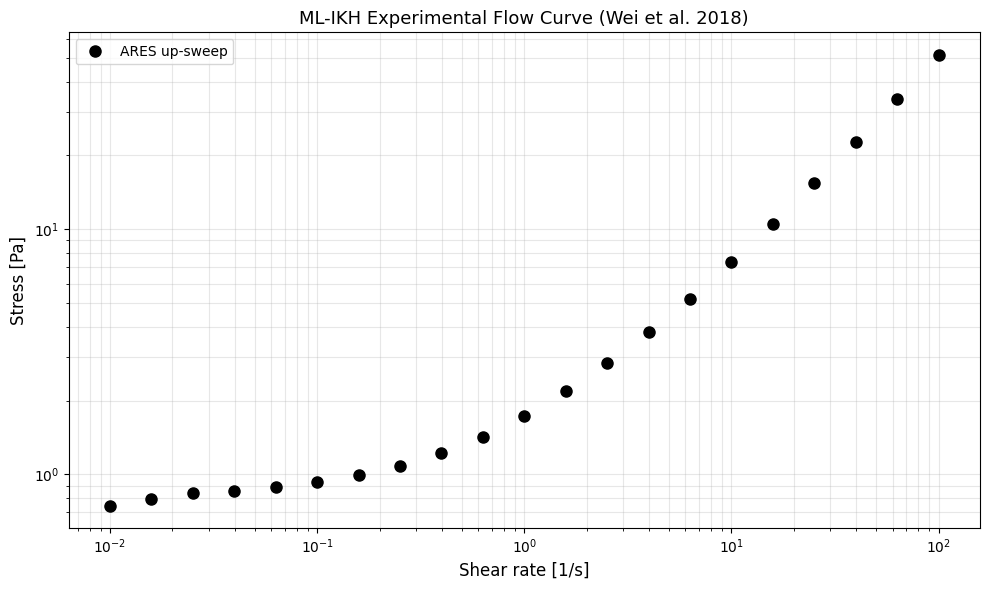

In [4]:
# Plot raw data
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=8, label="ARES up-sweep")

ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("ML-IKH Experimental Flow Curve (Wei et al. 2018)", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Initial Fit

We fit the FIKH model with a moderate fractional order ($\alpha = 0.7$) as starting point.

In [5]:
# Create FIKH model (isothermal, fractional order 0.7)
model = FIKH(include_thermal=False, alpha_structure=0.7)

t0 = time.time()
model.fit(gamma_dot, stress, test_mode="flow_curve")
t_nlsq = time.time() - t0

# Get parameter names (isothermal)
param_names = get_fikh_param_names(include_thermal=False)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=12 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.762972s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=4.1340 | elapsed=2.763s | final_gradient_norm=1.1439e-06


NLSQ fit time: 3.17 s

Fitted parameters:
  G               = 1000
  eta             = 1.527e+06
  C               = 2.11e+04
  gamma_dyn       = 2.96
  m               = 0.5093
  sigma_y0        = 1.328
  delta_sigma_y   = 0.03586
  tau_thix        = 3.777e+07
  Gamma           = 3125
  alpha_structure = 0.7
  eta_inf         = 0.5119
  mu_p            = 0.001036


In [6]:
# Compute fit quality
stress_pred = model.predict(gamma_dot, test_mode="flow_curve")
metrics = compute_fit_quality(stress, stress_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")
print(f"  NRMSE: {metrics['NRMSE']:.4%}")


Fit Quality:
  R^2:   0.997611
  RMSE:  0.6275 Pa
  NRMSE: 1.2374%


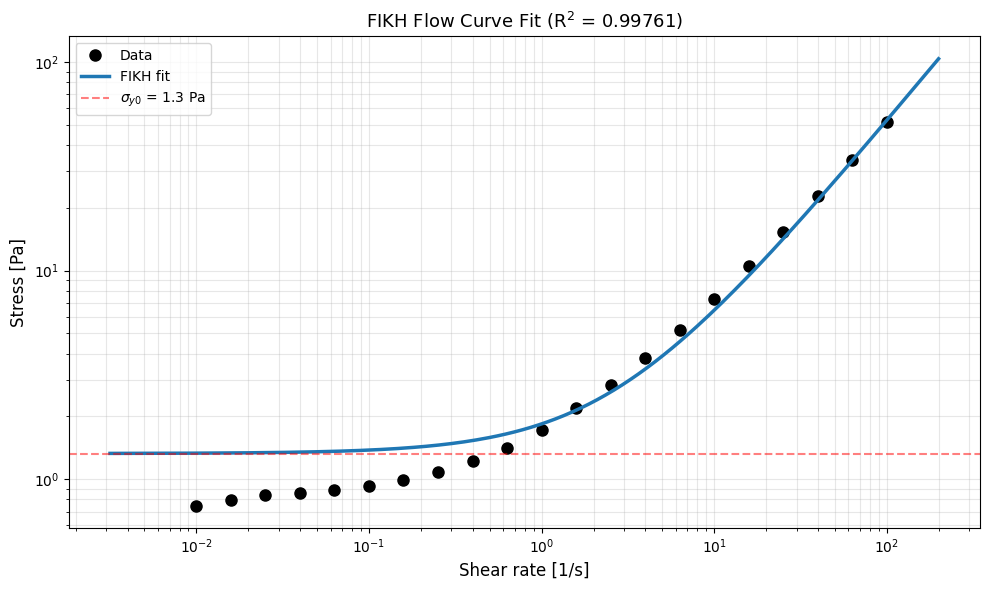

In [7]:
# Plot fit with data
gamma_dot_fine = np.logspace(
    np.log10(gamma_dot.min()) - 0.5,
    np.log10(gamma_dot.max()) + 0.3,
    200,
)
stress_pred_fine = model.predict(gamma_dot_fine, test_mode="flow_curve")

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=8, label="Data")
ax.loglog(gamma_dot_fine, stress_pred_fine, "-", lw=2.5, color="C0", label="FIKH fit")

# Add yield stress reference
sigma_y0 = model.parameters.get_value("sigma_y0")
ax.axhline(sigma_y0, color="red", linestyle="--", alpha=0.5, 
           label=f"$\\sigma_{{y0}}$ = {sigma_y0:.1f} Pa")

ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title(f"FIKH Flow Curve Fit (R$^2$ = {metrics['R2']:.5f})", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Alpha Exploration

This is the **key differentiator** of FIKH from classical IKH. We explore how the fractional order $\alpha$ affects:
1. Flow curve predictions
2. Memory kernel decay
3. Structure recovery dynamics

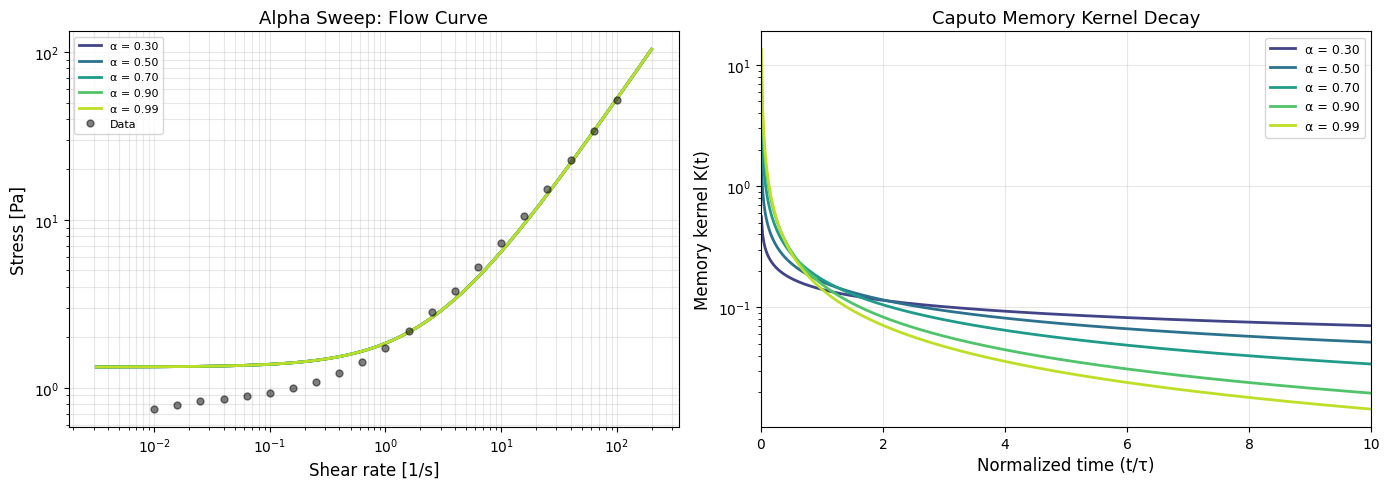

In [8]:
# Alpha sweep: Compare predictions across different fractional orders
alpha_values = [0.3, 0.5, 0.7, 0.9, 0.99]

fig = plot_alpha_sweep(
    model,
    protocol="flow_curve",
    alpha_values=alpha_values,
    x_data=gamma_dot_fine,
    figsize=(14, 5),
)

# Add data points to left panel
fig.axes[0].loglog(gamma_dot, stress, "ko", markersize=5, alpha=0.5, label="Data")
fig.axes[0].legend(fontsize=8, loc="best")

display(fig)
plt.close(fig)

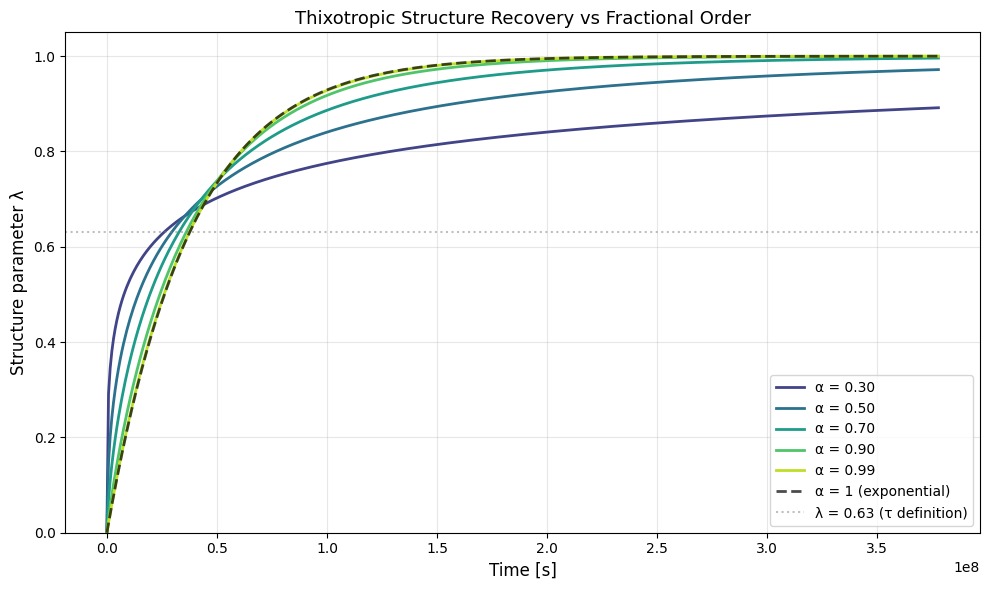

In [9]:
# Structure recovery: Show how alpha affects thixotropic rebuilding
tau_thix = model.parameters.get_value("tau_thix")

fig = plot_structure_recovery(
    alpha_values=alpha_values,
    tau_thix=tau_thix,
    t_max=10 * tau_thix,
    figsize=(10, 6),
)
display(fig)
plt.close(fig)

In [10]:
# Physical interpretation of fitted alpha
fitted_alpha = model.parameters.get_value("alpha_structure")
print_alpha_interpretation(fitted_alpha)

Fractional Order Interpretation: α = 0.700

Regime: Weak Memory

Approaching classical behavior with mild power-law tails.
Recovery is mostly exponential with slow corrections.
Suitable for: Mildly thixotropic materials.

Physical Implications:
  • Memory kernel decay: t^(-0.70)
  • Recovery time scale: > τ_thix × Γ(1+0.70) = 0.91 × τ_thix
  • Relaxation modulus: Power-law with exponent ≈ -0.70


### 5.1 Physical Analysis

Let's decompose the flow curve into its contributing mechanisms.

In [11]:
# Extract key physical parameters
sigma_y0 = model.parameters.get_value("sigma_y0")
delta_sigma_y = model.parameters.get_value("delta_sigma_y")
eta_inf = model.parameters.get_value("eta_inf")
tau_thix = model.parameters.get_value("tau_thix")
Gamma = model.parameters.get_value("Gamma")
alpha = model.parameters.get_value("alpha_structure")

print("Physical Analysis:")
print("=" * 55)
print(f"Fractional order:                    {alpha:.3f}")
print(f"Minimal yield stress (destructured): {sigma_y0:.2f} Pa")
print(f"Maximum yield stress (structured):   {sigma_y0 + delta_sigma_y:.2f} Pa")
print(f"Yield stress range:                  {delta_sigma_y:.2f} Pa")
print(f"High-shear viscosity:                {eta_inf:.4g} Pa.s")
print(f"Thixotropic rebuilding time:         {tau_thix:.2g} s")
print(f"Breakdown coefficient:               {Gamma:.4g}")

Physical Analysis:
Fractional order:                    0.700
Minimal yield stress (destructured): 1.33 Pa
Maximum yield stress (structured):   1.36 Pa
Yield stress range:                  0.04 Pa
High-shear viscosity:                0.5119 Pa.s
Thixotropic rebuilding time:         3.8e+07 s
Breakdown coefficient:               3125


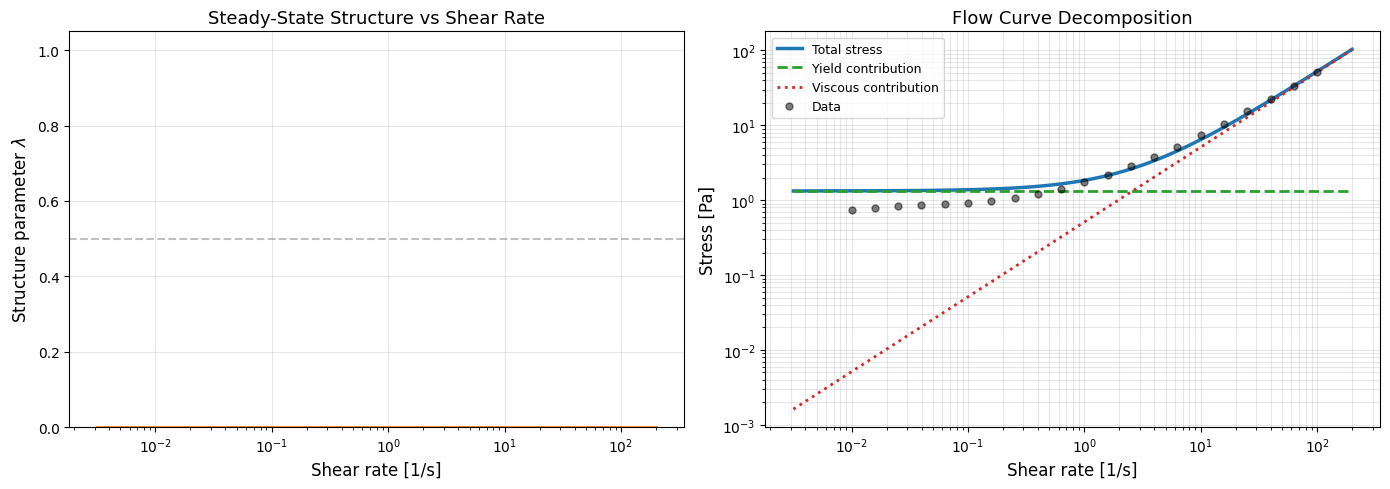

In [12]:
# Decompose flow curve into contributions
# Note: Steady-state structure is independent of alpha
lambda_ss = compute_fikh_structure_evolution(gamma_dot_fine, tau_thix, Gamma, alpha)
sigma_y_ss = compute_fikh_yield_stress(lambda_ss, sigma_y0, delta_sigma_y)

# Viscous contribution
sigma_viscous = eta_inf * gamma_dot_fine

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Structure evolution
ax1.semilogx(gamma_dot_fine, lambda_ss, lw=2, color="C1")
ax1.set_xlabel("Shear rate [1/s]", fontsize=12)
ax1.set_ylabel("Structure parameter $\\lambda$", fontsize=12)
ax1.set_title("Steady-State Structure vs Shear Rate", fontsize=13)
ax1.set_ylim(0, 1.05)
ax1.axhline(0.5, color="gray", linestyle="--", alpha=0.5)
ax1.grid(True, alpha=0.3)

# Right: Stress decomposition
ax2.loglog(gamma_dot_fine, stress_pred_fine, lw=2.5, color="C0", label="Total stress")
ax2.loglog(gamma_dot_fine, sigma_y_ss, "--", lw=2, color="C2", label="Yield contribution")
ax2.loglog(gamma_dot_fine, sigma_viscous, ":", lw=2, color="C3", label="Viscous contribution")
ax2.loglog(gamma_dot, stress, "ko", markersize=5, alpha=0.5, label="Data")

ax2.set_xlabel("Shear rate [1/s]", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Flow Curve Decomposition", fontsize=13)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Bayesian Inference with NUTS

### 6.1 Run NUTS

We use the NLSQ point estimates as warm-start values. The fractional order $\alpha$ is also inferred from data.

In [13]:
# Bayesian inference with NLSQ warm-start
initial_values = {
    name: model.parameters.get_value(name)
    for name in param_names
}
print("Warm-start values:")
for name, val in initial_values.items():
    print(f"  {name:15s} = {val:.4g}")

# Fast demo config
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

print(f"\nRunning NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    gamma_dot,
    stress,
    test_mode="flow_curve",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values:
  G               = 1000
  eta             = 1.527e+06
  C               = 2.11e+04
  gamma_dyn       = 2.96
  m               = 0.5093
  sigma_y0        = 1.328
  delta_sigma_y   = 0.03586
  tau_thix        = 3.777e+07
  Gamma           = 3125
  alpha_structure = 0.7
  eta_inf         = 0.5119
  mu_p            = 0.001036

Running NUTS: 200 warmup + 500 samples x 1 chain(s)


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<05:46,  2.01it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   1%|          | 7/700 [00:00<00:48, 14.38it/s, 1023 steps of size 2.40e-03. acc. prob=0.61]

warmup:   2%|▏         | 11/700 [00:00<00:35, 19.39it/s, 1023 steps of size 2.39e-03. acc. prob=0.75]

warmup:   2%|▏         | 15/700 [00:00<00:29, 23.02it/s, 1023 steps of size 3.05e-03. acc. prob=0.82]

warmup:   3%|▎         | 19/700 [00:00<00:26, 25.82it/s, 1023 steps of size 4.16e-03. acc. prob=0.85]

warmup:   3%|▎         | 23/700 [00:01<00:23, 28.24it/s, 1023 steps of size 5.68e-03. acc. prob=0.88]

warmup:   4%|▍         | 27/700 [00:01<00:22, 30.34it/s, 511 steps of size 7.96e-03. acc. prob=0.90] 

warmup:   4%|▍         | 31/700 [00:01<00:20, 32.29it/s, 511 steps of size 5.78e-03. acc. prob=0.90]

warmup:   5%|▌         | 35/700 [00:01<00:20, 31.96it/s, 1023 steps of size 7.84e-03. acc. prob=0.91]

warmup:   6%|▌         | 39/700 [00:01<00:20, 32.55it/s, 1023 steps of size 5.84e-03. acc. prob=0.92]

warmup:   6%|▌         | 43/700 [00:01<00:20, 31.92it/s, 1023 steps of size 7.44e-03. acc. prob=0.92]

warmup:   7%|▋         | 48/700 [00:01<00:18, 34.41it/s, 1023 steps of size 8.68e-03. acc. prob=0.93]

warmup:   8%|▊         | 53/700 [00:01<00:17, 36.97it/s, 1023 steps of size 5.81e-03. acc. prob=0.93]

warmup:   8%|▊         | 57/700 [00:02<00:18, 34.95it/s, 1023 steps of size 7.44e-03. acc. prob=0.93]

warmup:   9%|▊         | 61/700 [00:02<00:18, 33.78it/s, 1023 steps of size 8.25e-03. acc. prob=0.94]

warmup:  10%|▉         | 67/700 [00:02<00:15, 39.94it/s, 1023 steps of size 7.61e-03. acc. prob=0.94]

warmup:  10%|█         | 73/700 [00:02<00:14, 43.79it/s, 511 steps of size 4.32e-03. acc. prob=0.94] 

warmup:  11%|█         | 78/700 [00:02<00:14, 42.85it/s, 1023 steps of size 5.43e-03. acc. prob=0.94]

warmup:  12%|█▏        | 83/700 [00:02<00:15, 39.52it/s, 1023 steps of size 6.04e-03. acc. prob=0.94]

warmup:  13%|█▎        | 88/700 [00:02<00:17, 35.99it/s, 1023 steps of size 7.04e-03. acc. prob=0.95]

warmup:  13%|█▎        | 92/700 [00:02<00:17, 35.36it/s, 1023 steps of size 8.53e-03. acc. prob=0.95]

warmup:  14%|█▍        | 97/700 [00:03<00:16, 37.64it/s, 1023 steps of size 7.79e-03. acc. prob=0.95]

warmup:  14%|█▍        | 101/700 [00:03<00:16, 36.14it/s, 1023 steps of size 7.75e-02. acc. prob=0.95]

warmup:  15%|█▌        | 106/700 [00:03<00:15, 39.15it/s, 1023 steps of size 3.84e-03. acc. prob=0.94]

warmup:  16%|█▌        | 110/700 [00:03<00:16, 36.87it/s, 1023 steps of size 3.88e-03. acc. prob=0.95]

warmup:  16%|█▋        | 114/700 [00:03<00:16, 36.25it/s, 1023 steps of size 4.51e-03. acc. prob=0.95]

warmup:  17%|█▋        | 118/700 [00:03<00:16, 34.49it/s, 1023 steps of size 5.27e-03. acc. prob=0.95]

warmup:  18%|█▊        | 123/700 [00:03<00:15, 38.08it/s, 1023 steps of size 6.74e-03. acc. prob=0.95]

warmup:  18%|█▊        | 127/700 [00:03<00:15, 37.97it/s, 511 steps of size 7.84e-03. acc. prob=0.95] 

warmup:  19%|█▉        | 133/700 [00:04<00:13, 43.17it/s, 511 steps of size 1.02e-02. acc. prob=0.95]

warmup:  20%|██        | 140/700 [00:04<00:11, 49.60it/s, 511 steps of size 9.46e-03. acc. prob=0.96]

warmup:  21%|██        | 146/700 [00:04<00:10, 51.03it/s, 1023 steps of size 1.08e-02. acc. prob=0.96]

warmup:  22%|██▏       | 153/700 [00:04<00:09, 55.33it/s, 511 steps of size 5.88e-03. acc. prob=0.95] 

warmup:  23%|██▎       | 159/700 [00:04<00:10, 53.98it/s, 1023 steps of size 4.17e-03. acc. prob=0.95]

warmup:  24%|██▎       | 165/700 [00:04<00:11, 47.07it/s, 1023 steps of size 5.15e-03. acc. prob=0.95]

warmup:  24%|██▍       | 170/700 [00:04<00:11, 45.39it/s, 511 steps of size 6.22e-03. acc. prob=0.96] 

warmup:  25%|██▌       | 178/700 [00:04<00:09, 53.29it/s, 511 steps of size 7.44e-03. acc. prob=0.96]

warmup:  26%|██▋       | 184/700 [00:04<00:09, 54.56it/s, 511 steps of size 9.18e-03. acc. prob=0.96]

warmup:  28%|██▊       | 193/700 [00:05<00:08, 63.10it/s, 511 steps of size 1.09e-02. acc. prob=0.96]

sample:  29%|██▉       | 202/700 [00:05<00:07, 69.84it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  30%|███       | 210/700 [00:05<00:06, 70.83it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  31%|███       | 218/700 [00:05<00:07, 65.17it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  32%|███▏      | 225/700 [00:05<00:07, 64.27it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  33%|███▎      | 233/700 [00:05<00:06, 67.56it/s, 255 steps of size 8.96e-03. acc. prob=0.99]

sample:  34%|███▍      | 241/700 [00:05<00:06, 68.74it/s, 1023 steps of size 8.96e-03. acc. prob=0.99]

sample:  35%|███▌      | 248/700 [00:05<00:06, 66.53it/s, 511 steps of size 8.96e-03. acc. prob=0.99] 

sample:  37%|███▋      | 256/700 [00:05<00:06, 68.32it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  38%|███▊      | 265/700 [00:06<00:06, 70.97it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  39%|███▉      | 273/700 [00:06<00:06, 68.60it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  40%|████      | 280/700 [00:06<00:06, 67.98it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  41%|████      | 288/700 [00:06<00:05, 69.20it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  42%|████▏     | 295/700 [00:06<00:06, 67.26it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  43%|████▎     | 303/700 [00:06<00:05, 70.14it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  44%|████▍     | 311/700 [00:06<00:05, 72.66it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  46%|████▌     | 319/700 [00:06<00:05, 71.81it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  47%|████▋     | 327/700 [00:06<00:05, 69.45it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  48%|████▊     | 334/700 [00:07<00:05, 69.44it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  49%|████▉     | 342/700 [00:07<00:05, 71.19it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  50%|█████     | 351/700 [00:07<00:04, 72.88it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  51%|█████▏    | 359/700 [00:07<00:04, 74.00it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  52%|█████▏    | 367/700 [00:07<00:04, 70.74it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  54%|█████▎    | 375/700 [00:07<00:04, 68.31it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  55%|█████▍    | 382/700 [00:07<00:04, 66.82it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  56%|█████▌    | 390/700 [00:07<00:04, 69.32it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  57%|█████▋    | 397/700 [00:07<00:04, 68.93it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  58%|█████▊    | 405/700 [00:08<00:04, 70.68it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  59%|█████▉    | 413/700 [00:08<00:04, 68.84it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  60%|██████    | 420/700 [00:08<00:04, 67.29it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  61%|██████    | 428/700 [00:08<00:03, 69.37it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  62%|██████▏   | 435/700 [00:08<00:04, 65.74it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  63%|██████▎   | 442/700 [00:08<00:04, 64.02it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  64%|██████▍   | 449/700 [00:08<00:03, 65.25it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  65%|██████▌   | 456/700 [00:08<00:03, 63.03it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  66%|██████▌   | 463/700 [00:08<00:03, 63.09it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  67%|██████▋   | 470/700 [00:09<00:03, 61.60it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  68%|██████▊   | 477/700 [00:09<00:03, 60.90it/s, 255 steps of size 8.96e-03. acc. prob=0.99]

sample:  69%|██████▉   | 485/700 [00:09<00:03, 64.53it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  71%|███████   | 494/700 [00:09<00:02, 69.82it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  72%|███████▏  | 502/700 [00:09<00:03, 65.46it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  73%|███████▎  | 510/700 [00:09<00:02, 68.40it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  74%|███████▍  | 517/700 [00:09<00:02, 66.03it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  75%|███████▌  | 525/700 [00:09<00:02, 66.99it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  76%|███████▋  | 534/700 [00:10<00:02, 73.11it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  77%|███████▋  | 542/700 [00:10<00:02, 68.75it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  78%|███████▊  | 549/700 [00:10<00:02, 67.57it/s, 255 steps of size 8.96e-03. acc. prob=0.99]

sample:  79%|███████▉  | 556/700 [00:10<00:02, 67.02it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  80%|████████  | 563/700 [00:10<00:02, 65.20it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  82%|████████▏ | 571/700 [00:10<00:01, 67.70it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  83%|████████▎ | 579/700 [00:10<00:01, 68.44it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  84%|████████▍ | 587/700 [00:10<00:01, 70.39it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  85%|████████▌ | 595/700 [00:10<00:01, 65.82it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  86%|████████▌ | 602/700 [00:11<00:01, 65.55it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  87%|████████▋ | 609/700 [00:11<00:01, 63.79it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  88%|████████▊ | 616/700 [00:11<00:01, 63.95it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  89%|████████▉ | 624/700 [00:11<00:01, 67.16it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  90%|█████████ | 631/700 [00:11<00:01, 67.22it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  91%|█████████ | 638/700 [00:11<00:00, 65.23it/s, 1023 steps of size 8.96e-03. acc. prob=0.99]

sample:  92%|█████████▏| 646/700 [00:11<00:00, 68.16it/s, 511 steps of size 8.96e-03. acc. prob=0.99] 

sample:  93%|█████████▎| 653/700 [00:11<00:00, 65.88it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  94%|█████████▍| 660/700 [00:11<00:00, 65.95it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  95%|█████████▌| 667/700 [00:12<00:00, 63.72it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  96%|█████████▋| 675/700 [00:12<00:00, 65.29it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  97%|█████████▋| 682/700 [00:12<00:00, 64.72it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample:  99%|█████████▉| 692/700 [00:12<00:00, 71.98it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:12<00:00, 70.34it/s, 511 steps of size 8.96e-03. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:12<00:00, 55.92it/s, 511 steps of size 8.96e-03. acc. prob=0.99]


Bayesian inference time: 15.2 s


### 6.2 Convergence Diagnostics

Check R-hat (target < 1.05) and effective sample size (ESS, target > 100 for demo).

In [14]:
# Convergence diagnostics table
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    1.0000       500      PASS
            eta    1.0000       500      PASS
              C    1.0000       500      PASS
      gamma_dyn    1.0000       500      PASS
              m    1.0000       500      PASS
       sigma_y0    1.0000       500      PASS
  delta_sigma_y    1.0000       500      PASS
       tau_thix    1.0000       500      PASS
          Gamma    1.0000       500      PASS
alpha_structure    1.0000       500      PASS
        eta_inf    1.0000       500      PASS
           mu_p    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


### 6.3 ArviZ Diagnostic Plots

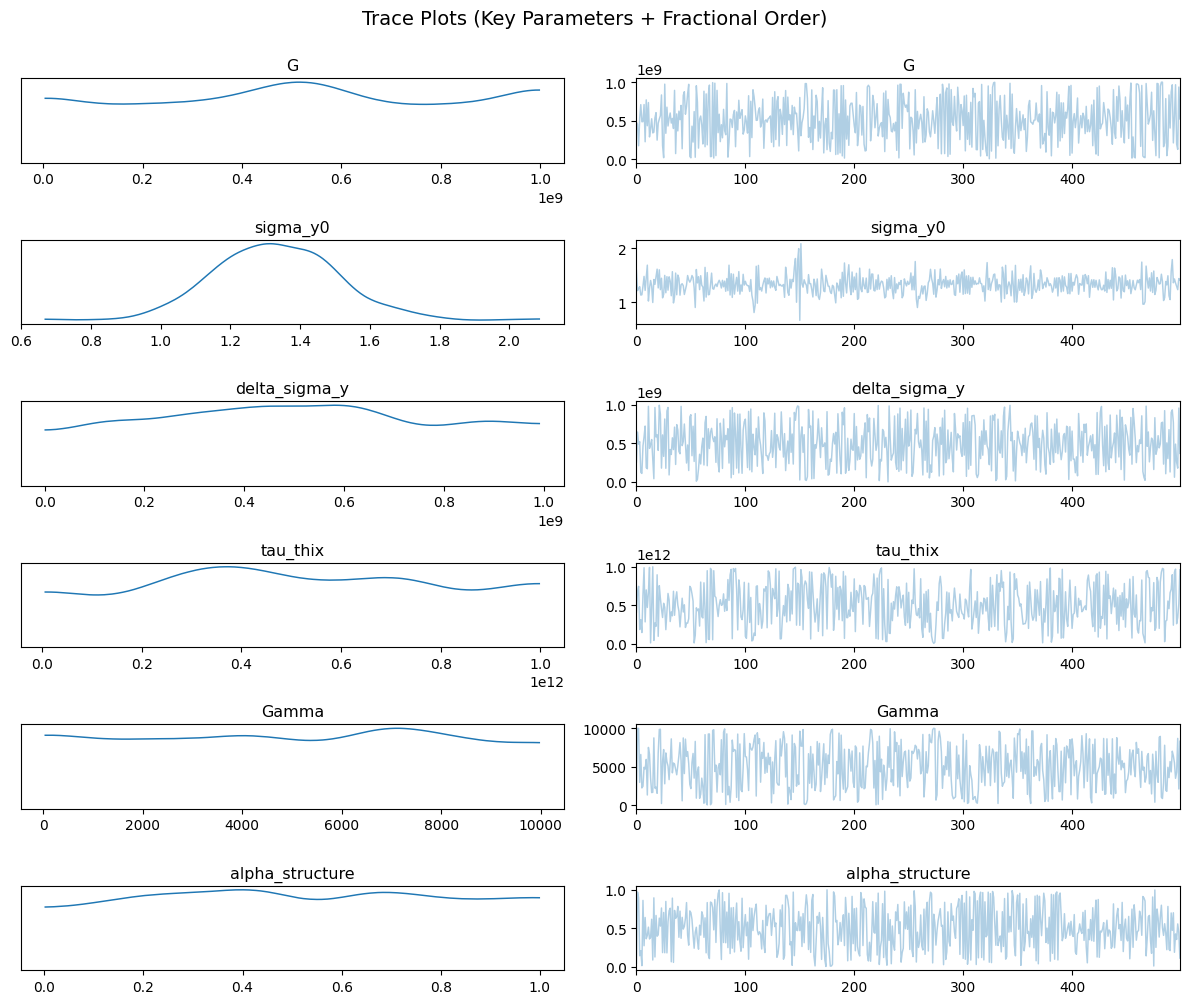

In [15]:
# Trace plots for key parameters (including alpha_structure)
idata = result.to_inference_data()

# Key parameters including fractional order
key_params = ["G", "sigma_y0", "delta_sigma_y", "tau_thix", "Gamma", "alpha_structure"]
axes = az.plot_trace(idata, var_names=key_params, figsize=(12, 10))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots (Key Parameters + Fractional Order)", fontsize=14, y=1.00)
plt.tight_layout()
display(fig)
plt.close(fig)

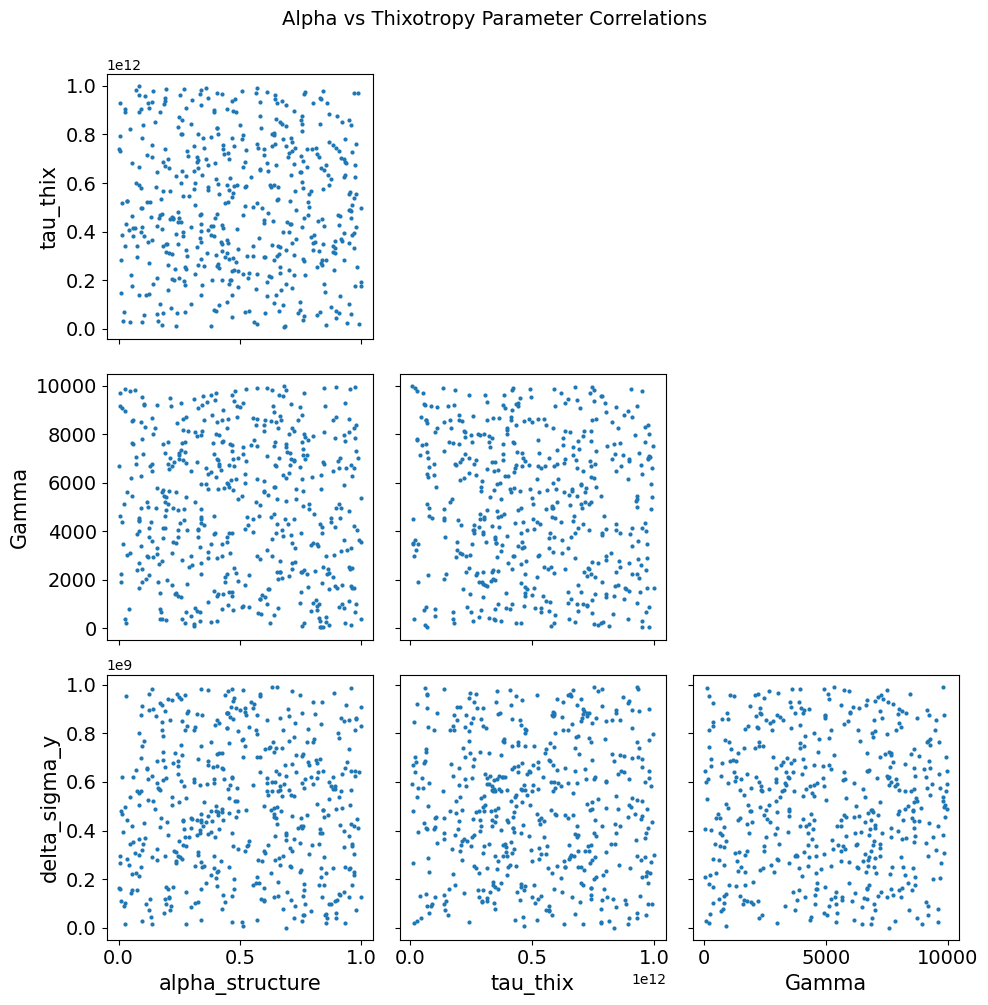

In [16]:
# Pair plot: alpha_structure vs thixotropy parameters
alpha_thix_params = ["alpha_structure", "tau_thix", "Gamma", "delta_sigma_y"]
axes = az.plot_pair(
    idata,
    var_names=alpha_thix_params,
    kind="scatter",
    divergences=True,
    figsize=(10, 10),
)
fig = axes.ravel()[0].figure
fig.suptitle("Alpha vs Thixotropy Parameter Correlations", fontsize=14, y=1.00)
plt.tight_layout()
display(fig)
plt.close(fig)

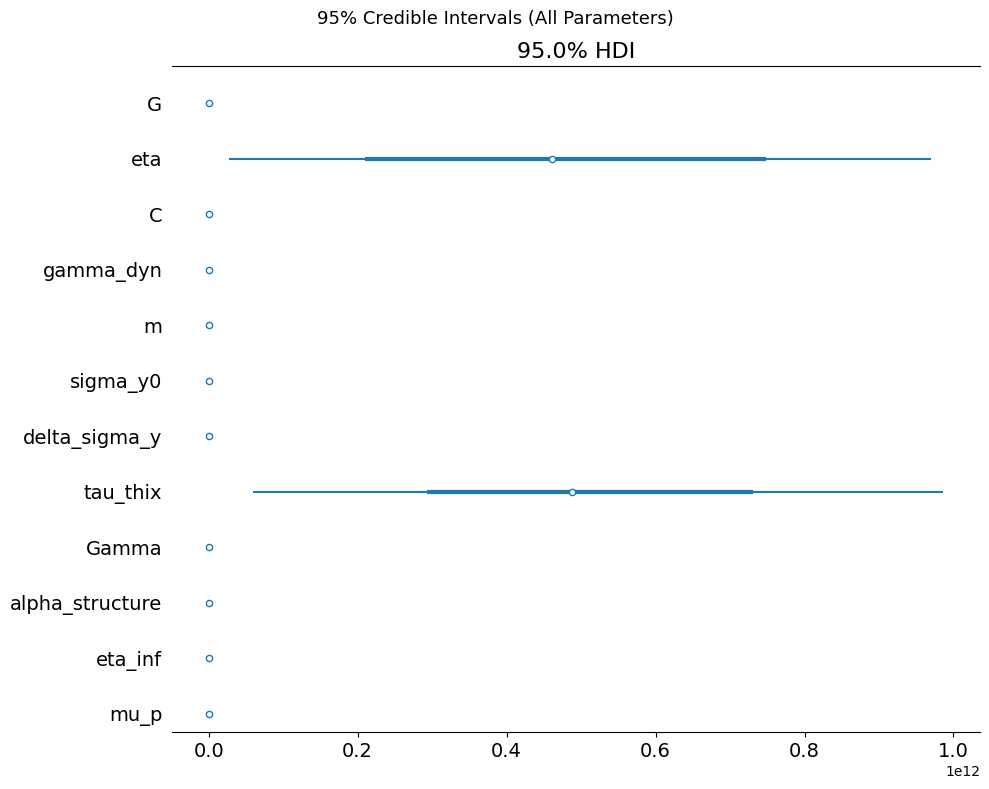

In [17]:
# Forest plot (credible intervals) for all parameters
axes = az.plot_forest(
    idata,
    var_names=param_names,
    combined=True,
    hdi_prob=0.95,
    figsize=(10, 8),
)
fig = axes.ravel()[0].figure
fig.suptitle("95% Credible Intervals (All Parameters)", fontsize=13)
plt.tight_layout()
display(fig)
plt.close(fig)

### 6.4 Posterior Predictive Check

Validate the model by comparing data against predictions from posterior samples.

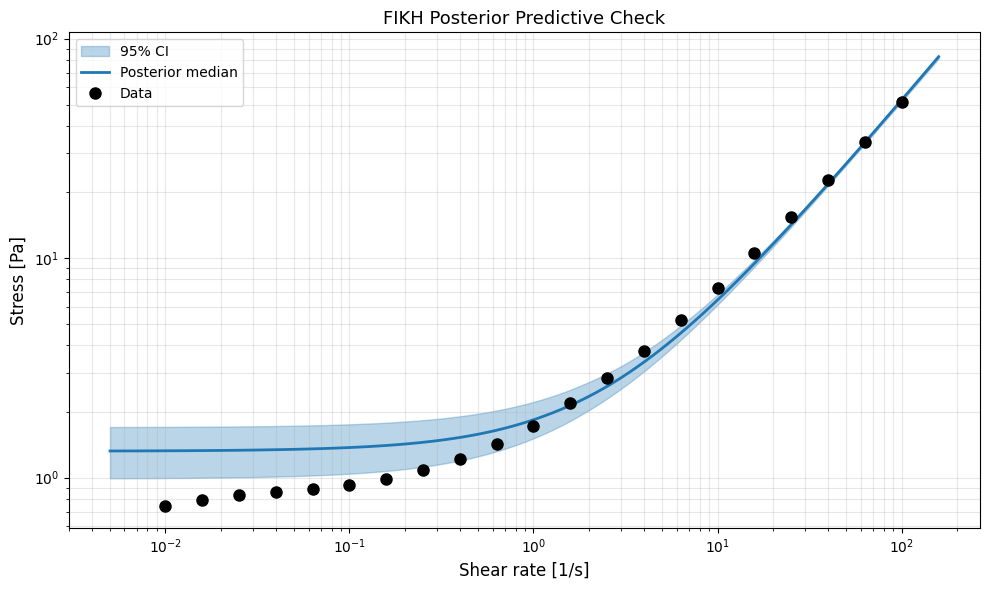

In [18]:
# Posterior predictive with 95% credible intervals
posterior = result.posterior_samples
n_draws = min(200, len(list(posterior.values())[0]))
gamma_dot_pred = np.logspace(
    np.log10(gamma_dot.min()) - 0.3,
    np.log10(gamma_dot.max()) + 0.2,
    100,
)

pred_samples = []
for i in range(n_draws):
    params_i = jnp.array([posterior[name][i] for name in param_names])
    pred_i = model.model_function(jnp.array(gamma_dot_pred), params_i, test_mode="flow_curve")
    pred_samples.append(np.array(pred_i))

pred_samples = np.array(pred_samples)
pred_median = np.median(pred_samples, axis=0)
pred_lo = np.percentile(pred_samples, 2.5, axis=0)
pred_hi = np.percentile(pred_samples, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(gamma_dot_pred, pred_lo, pred_hi, alpha=0.3, color="C0", label="95% CI")
ax.loglog(gamma_dot_pred, pred_median, "-", lw=2, color="C0", label="Posterior median")
ax.loglog(gamma_dot, stress, "ko", markersize=8, label="Data")
ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("FIKH Posterior Predictive Check", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

### 6.5 Parameter Summary

Compare NLSQ point estimates with Bayesian posterior.

In [19]:
# NLSQ vs Bayesian comparison table
print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G          1000      5.09e+08  [2.429e+07, 9.794e+08]
            eta     1.527e+06     4.616e+11  [2.912e+10, 9.727e+11]
              C      2.11e+04      4.88e+08  [2.185e+07, 9.816e+08]
      gamma_dyn          2.96          4821  [88.89, 9806]
              m        0.5093         1.808  [0.6225, 2.881]
       sigma_y0         1.328         1.327  [1.006, 1.686]
  delta_sigma_y       0.03586     4.866e+08  [3.591e+07, 9.618e+08]
       tau_thix     3.777e+07     4.883e+11  [2.96e+10, 9.726e+11]
          Gamma          3125          4983  [238.3, 9800]
alpha_structure           0.7        0.4856  [0.02848, 0.9699]
        eta_inf        0.5119        0.2446  [0.005883, 0.5049]
           mu_p      0.001036        0.2653  [0.006344, 0.5044]


In [20]:
# Highlight alpha_structure posterior
alpha_samples = posterior["alpha_structure"]
alpha_median = np.median(alpha_samples)
alpha_lo, alpha_hi = np.percentile(alpha_samples, [2.5, 97.5])

print("\nFractional Order Posterior:")
print("=" * 50)
print(f"  alpha_structure: {alpha_median:.3f} [{alpha_lo:.3f}, {alpha_hi:.3f}]")
print("\nInterpretation:")
print_alpha_interpretation(alpha_median)


Fractional Order Posterior:
  alpha_structure: 0.486 [0.028, 0.970]

Interpretation:
Fractional Order Interpretation: α = 0.486

Regime: Strong Memory

Significant power-law character. Slow recovery dynamics.
Thixotropic rebuilding takes much longer than τ_thix.
Suitable for: Colloidal gels, waxy crude oils.

Physical Implications:
  • Memory kernel decay: t^(-0.49)
  • Recovery time scale: > τ_thix × Γ(1+0.49) = 0.89 × τ_thix
  • Relaxation modulus: Power-law with exponent ≈ -0.49


## 7. Physical Interpretation

### FIKH vs Classical IKH

The key difference between FIKH and classical IKH is the **memory kernel**:

| Aspect | Classical IKH | FIKH |
|--------|---------------|------|
| Memory kernel | $\delta(t)$ (instantaneous) | $t^{-\alpha}/\Gamma(1-\alpha)$ (power-law) |
| Recovery dynamics | Exponential | Stretched exponential / Mittag-Leffler |
| Characteristic time | $\tau_{thix}$ | $\tau_{thix} \cdot \Gamma(1+\alpha)$ |
| Physical basis | Markovian kinetics | Non-Markovian, memory effects |

### When to Use FIKH

FIKH is appropriate when:
1. Material shows **slow thixotropic recovery** with power-law tails
2. Classical IKH gives poor fits to **long-time relaxation** data
3. Material exhibits **aging effects** or non-Markovian kinetics
4. Microstructure involves **hierarchical relaxation** (e.g., colloidal gels)

### Steady-State Behavior

Note: The **steady-state** flow curve is independent of $\alpha$. The fractional order affects:
- Transient approach to steady state
- Stress relaxation dynamics
- Startup shear overshoot timing
- Creep acceleration behavior

## 8. Save Results

Save calibrated parameters for synthetic data generation in downstream notebooks.

In [21]:
# Save results for downstream notebooks
save_fikh_results(model, result, "fikh", "flow_curve", param_names)

print("\nParameters saved for synthetic data generation in:")
print("  - NB03: Stress Relaxation (power-law tails vs exponential)")
print("  - NB05: SAOS (alpha effect on moduli)")

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fikh/flow_curve/
  nlsq_params_flow_curve.json: 12 parameters
  posterior_flow_curve.json: 500 draws

Parameters saved for synthetic data generation in:
  - NB03: Stress Relaxation (power-law tails vs exponential)
  - NB05: SAOS (alpha effect on moduli)


## Key Takeaways

1. **FIKH extends IKH with fractional structure evolution**:
   $D^\alpha_C \lambda = (1-\lambda)/\tau_{thix} - \Gamma\lambda|\dot{\gamma}^p|$

2. **Fractional order $\alpha$ controls memory**:
   - $\alpha \to 0$: Strong power-law memory (slow recovery)
   - $\alpha \to 1$: Classical IKH (exponential recovery)

3. **12 parameters** (isothermal) including **alpha_structure**:
   - Same as IKH: G, eta, C, gamma_dyn, m, sigma_y0, delta_sigma_y, tau_thix, Gamma, eta_inf, mu_p
   - New: **alpha_structure** (fractional order)

4. **Steady-state flow curve is alpha-independent**:
   - $\alpha$ affects transient dynamics, not equilibrium
   - Flow curve data alone may not constrain $\alpha$ well

5. **NLSQ warm-start is critical** for efficient Bayesian inference

6. **Parameters calibrated here** will be used for:
   - Relaxation (NB03): Power-law tails show alpha effect
   - SAOS (NB05): Alpha modifies frequency response

### Next Steps

- **NB02**: Startup shear (stress overshoot timing affected by alpha)
- **NB03**: Stress relaxation (synthetic data, power-law vs exponential decay)
- **NB04**: Creep response (delayed yielding with memory effects)
- **NB05**: SAOS moduli (synthetic data from calibrated parameters)
- **NB06**: LAOS harmonics (intra-cycle memory effects)